In [25]:
# #!/usr/bin/env python

# """Notebook for rapid prompt-based annotation. Box to mask using Segment Anything Model"""

# __author__      = "Sahib Julka <sahib.julka@uni-passau.de>"
# __copyright__   = "GPL"


In [60]:
import torch
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from utils import encode_image
from jupyter_bbox_widget import BBoxWidget


In [61]:
DEVICE = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = os.path.join("sam","sam_vit_h_4b8939.pth")

In [62]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_predictor = SamPredictor(sam)

In [71]:
!ls processed/images/

c1_wbdX9_20010108T131000_131010_fce330_chorus0_psd.png
c1_wbdX9_20010108T131020_131030_fce330_chorus0_psd.png
c1_wbdX9_20010108T131040_131050_fce330_chorus0_psd.png
c1_wbdX9_20010108T131100_131110_fce331_chorus0_psd.png
c1_wbdX9_20010108T131120_131130_fce331_chorus0_psd.png
c1_wbdX9_20010108T131140_131150_fce332_chorus0_psd.png
c1_wbdX9_20010108T131200_131210_fce332_chorus0_psd.png
c1_wbdX9_20010108T131220_131230_fce333_chorus0_psd.png
c1_wbdX9_20010108T131240_131250_fce333_chorus0_psd.png
c1_wbdX9_20010108T131300_131310_fce334_chorus0_psd.png
c1_wbdX9_20010108T131320_131330_fce334_chorus0_psd.png
c1_wbdX9_20010108T131400_131410_fce335_chorus0_psd.png
c1_wbdX9_20010108T131420_131430_fce336_chorus0_psd.png
c1_wbdX9_20010108T131500_131510_fce337_chorus1_psd.png
c1_wbdX9_20010108T131520_131530_fce337_chorus1_psd.png
c1_wbdX9_20010108T131600_131610_fce339_chorus0_psd.png
c1_wbdX9_20010108T131620_131630_fce339_chorus1_psd.png
c1_wbdX9_20010108T131640_131650_fce340_chorus1_psd.png
c1_wbdX9_2

c1_wbdX9_20040106T124240_124250_fce332_chorus1_psd.png
c1_wbdX9_20040106T124300_124310_fce333_chorus1_psd.png
c1_wbdX9_20040106T124320_124330_fce334_chorus1_psd.png
c1_wbdX9_20040106T124340_124350_fce335_chorus1_psd.png
c1_wbdX9_20040106T124400_124410_fce336_chorus0_psd.png
c1_wbdX9_20040106T124420_124430_fce336_chorus1_psd.png
c1_wbdX9_20040106T124440_124450_fce337_chorus1_psd.png
c1_wbdX9_20040206T104000_104020_fce321_chorus1_psd.png
c1_wbdX9_20040206T104020_104040_fce321_chorus1_psd.png
c1_wbdX9_20040206T104040_104100_fce322_chorus0_psd.png
c1_wbdX9_20040206T104100_104120_fce323_chorus1_psd.png
c1_wbdX9_20040206T104120_104140_fce323_chorus1_psd.png
c1_wbdX9_20040206T104140_104200_fce324_chorus1_psd.png
c1_wbdX9_20040206T104200_104220_fce324_chorus1_psd.png
c1_wbdX9_20040206T104220_104240_fce325_chorus0_psd.png
c1_wbdX9_20040206T104240_104300_fce326_chorus1_psd.png
c1_wbdX9_20040206T104300_104320_fce327_chorus1_psd.png
c1_wbdX9_20040206T104320_104340_fce327_chorus1_psd.png
c1_wbdX9_2

In [72]:
DATA_PATH = 'processed/images'
IMAGES = []
filenames = []
for fn in os.listdir(DATA_PATH):
    #if fn.endswith('cropped.png'):
        filenames.append(fn)
        IMAGES.append(os.path.join(DATA_PATH, fn))
        
        #widget.image = encode_image(IMAGE_PATH)

In [83]:
i = np.random.randint(1, len(filenames))
widget = BBoxWidget()
widget.image = encode_image(IMAGES[i])
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [52]:
widget.bboxes

[{'x': 4, 'y': 311, 'width': 273, 'height': 172, 'label': ''},
 {'x': 458, 'y': 339, 'width': 287, 'height': 125, 'label': ''},
 {'x': 761, 'y': 362, 'width': 772, 'height': 127, 'label': ''},
 {'x': 1555, 'y': 326, 'width': 361, 'height': 149, 'label': ''}]

In [53]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}
boxes = []
#box = widget.bboxes[0] if widget.bboxes else default_box
for box in widget.bboxes:
    box = np.array([
        box['x'], 
        box['y'], 
        box['x'] + box['width'], 
        box['y'] + box['height']
    ])
    boxes.append(box)

In [54]:
boxes = np.array(boxes)
boxes

array([[   4,  311,  277,  483],
       [ 458,  339,  745,  464],
       [ 761,  362, 1533,  489],
       [1555,  326, 1916,  475]])

In [55]:
import cv2
import numpy as np
import supervision as sv


boxes = torch.Tensor(boxes).to(DEVICE)
image_bgr = cv2.imread(IMAGES[i])
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)
transformed_boxes = mask_predictor.transform.apply_boxes_torch(boxes, image_rgb.shape[:2])


masks, scores, logits = mask_predictor.predict_torch(
    point_coords = None,
    point_labels = None,
    boxes=transformed_boxes,
    multimask_output=False
)
mask = masks.sum(axis = 0).cpu().numpy()

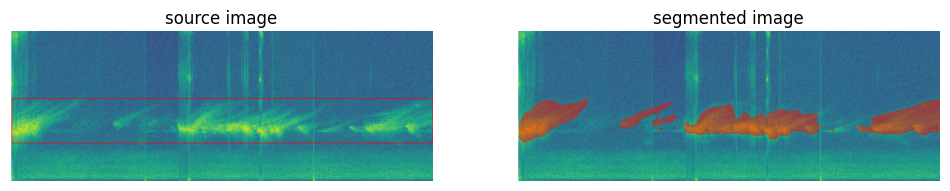

In [56]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=mask),
    mask=mask
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

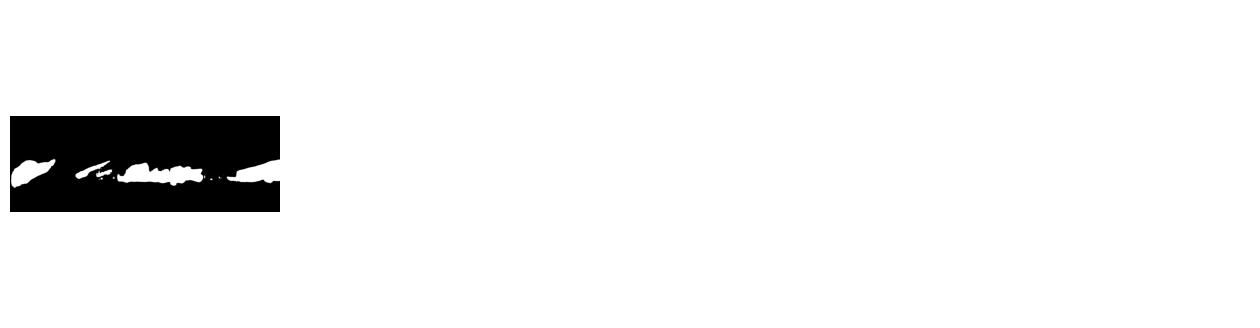

In [57]:
import supervision as v

sv.plot_images_grid(
    images=mask,
    grid_size=(1, 4),
    size=(16, 4)
)

In [58]:
os.makedirs("processed/masks/", exist_ok = True)
np.save('processed/masks/{}.npy'.format(filenames[i].split('.png')[0]), mask)

In [59]:
!ls processed/masks | wc -l

5
